In [1]:
import torch
from torch import nn
from metann.meta import MAMLpp, mamlpp_evaluator, RMSPropLearner
import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from models import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mlp().to(device)
maml = MAMLpp(model, 5, 5, lr=1e-1, evaluator=weighted_mse_evaluator(weighting=mixed_gaussian(epsilon=0.5, c=0.5)))
control = MAMLpp(mlp().to(device), 5000, 5000, lr=1e-1, evaluator=weighted_mse_evaluator(weighting=mixed_gaussian(epsilon=0.5, c=0.5)),first_order=True)

In [41]:
batch_size= 1
iterations = 80000
single_epochs = 500
epochs = iterations//single_epochs

writer = SummaryWriter()
optimizer = optim.Adam(maml.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs,
                                                 eta_min=1e-5)

data_provider = data.MetaZDataProvider(root='./data/mppt2/train', batch_size=[9, 48, 49, 52, 116, 134],
                                       batch_size_eval=40, length=iterations)
it = iter(data_provider)
itn = zip(*[it for _ in range(batch_size)])
for i, datasets in enumerate(itn):
    n = i*batch_size
    loss = 0
    optimizer.zero_grad()
    for dataset in datasets:
        (x, y), (x_test, y_test) = dataset
        x = x.to(device)
        y = y.to(device)
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        # with torch.no_grad():
        #     print(mse_evaluator(maml.model, (x, y)).item())
        model = maml((x, y))
        running_loss, loss =  mamlpp_evaluator(model, (x_test, y_test), steps=5,
                                               evaluator=weighted_mse_evaluator(weighting=mixed_gaussian(epsilon=0.5, c=0.5)),
                                               gamma=max(0.,1-n/(0.6*iterations)))
    loss = loss/batch_size
    running_loss = running_loss/batch_size
    writer.add_scalar('MPPT/loss', loss.item(), n)
    writer.add_scalar('MPPT/running', running_loss.item(), n)
    running_loss.backward()
    torch.nn.utils.clip_grad_value_(maml.parameters(), 1)
    optimizer.step()
    
    if n%single_epochs == 0:
        epoch = n//single_epochs
        scheduler.step()
        writer.add_scalar('MPPT/lr', scheduler.get_last_lr()[0], n)

#     print(loss.item())

In [42]:
torch.save(maml.state_dict(), './saved_models/mppt2.pth')

In [3]:
maml.load_state_dict(torch.load('./saved_models/mppt2.pth'))
maml.eval()

MAMLpp(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=80, bias=True)
    (9): ReLU()
    (10): Linear(in_features=80, out_features=2, bias=True)
  )
)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
mpl = matplotlib
import pandas as pd
%matplotlib inline
from matplotlib import rc, rcParams

r = r'Magnitude (dB)'
theta = r'Phase (rad)'
f = r'Frequency (Hz)'

predict = "MAML prediction"
measure = "Measured results"
comp = "ANN prediction"
sp = 'Small sample data'

df = pd.DataFrame({'mod':[], f:[], 'value':[], 'type':[], 'conf':[],})
df_e = pd.DataFrame({'mod':[], f:[], 'value':[], 'type':[], 'conf':[],})

data_provider = data.MetaZDataProvider(root='./data/mppt2/test/',
                                       batch_size=[9, 48, 49, 52, 116, 134], 
                                       batch_size_eval=135, 
                                       length=4, sampler='sequence')
maml.eval()

MAMLpp(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=80, bias=True)
    (9): ReLU()
    (10): Linear(in_features=80, out_features=2, bias=True)
  )
)

In [98]:
sns.set(style='ticks',font='Times New Roman',font_scale=1.4)
size = 20
mpl.rcParams['xtick.labelsize'] = size 
mpl.rcParams['ytick.labelsize'] = size 

In [44]:
for i, dataset in enumerate(data_provider):
    (x, y), (x_test, y_test) = dataset
    x = x.to(device)
    y = y.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    model = maml((x, y))
    ys = model(x_test)
    print(mse_evaluator(model, (x_test, y_test)).item(), '/',
          weighted_mse_evaluator(weighting=mixed_gaussian(epsilon=0.5, c=0.5))(model, (x_test, y_test)).item())
    for i in range(len(ys)):
        df = df.append({'mod':predict,f:10**x_test[i][0].item(), 'value':20*ys[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':predict,f:10**x_test[i][0].item(), 'value':ys[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':measure,f:10**x_test[i][0].item(), 'value':20*y_test[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':measure,f:10**x_test[i][0].item(), 'value':y_test[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)     

0.020286276936531067 / 0.020099511370062828
0.021946344524621964 / 0.020405391231179237
0.050684716552495956 / 0.04859945923089981
0.015110538341104984 / 0.01275266520678997


In [5]:
control.eval()

def diff_rt(r1, r2):
    x1 = 10**r1[0]*torch.cos(r1[1])
    y1 = 10**r1[0]*torch.sin(r1[1])
    x2 = 10**r2[0]*torch.cos(r2[1])
    y2 = 10**r2[0]*torch.sin(r2[1])
    x = x1-x2
    y = y1-y2
    return torch.log10(x**2+y**2)/2, torch.atan2(y,x)
    

for i, dataset in enumerate(data_provider):
    (x, y), (x_test, y_test) = dataset
    x = x.to(device)
    y = y.to(device)
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    model = maml((x, y))
    trained = control((x,y))
    ys = model(x_test)
    ys_control = trained(x_test)
    print(mse_evaluator(model, (x_test, y_test)).item(), '/',
          weighted_mse_evaluator(weighting=mixed_gaussian(epsilon=0.5, c=0.5))(model, (x_test, y_test)).item())
    for i in range(len(ys)):
        df = df.append({'mod':predict,f:10**x_test[i][0].item(), 'value':20*ys[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':predict,f:10**x_test[i][0].item(), 'value':ys[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':comp,f:10**x_test[i][0].item(), 'value':20*ys_control[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':comp,f:10**x_test[i][0].item(), 'value':ys_control[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':measure,f:10**x_test[i][0].item(), 'value':20*y_test[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':measure,f:10**x_test[i][0].item(), 'value':y_test[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)  
        
        df_e = df_e.append({'mod':predict,f:10**x_test[i][0].item(), 'value':(ys[i][0]-y_test[i][0]).item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df_e = df_e.append({'mod':predict,f:10**x_test[i][0].item(), 'value':(ys[i][1]-y_test[i][1]).item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)
        df_e = df_e.append({'mod':comp,f:10**x_test[i][0].item(), 'value':(ys_control[i][0]-y_test[i][0]).item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df_e = df_e.append({'mod':comp,f:10**x_test[i][0].item(), 'value':(ys_control[i][1]-y_test[i][1]).item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)
    for i in range(len(x)):
        df = df.append({'mod':sp,f:10**x[i][0].item(), 'value':20*y[i][0].item(), 'type':r, 'conf':dataset.idx,}, ignore_index=True)
        df = df.append({'mod':sp,f:10**x[i][0].item(), 'value':y[i][1].item(), 'type':theta, 'conf':dataset.idx,}, ignore_index=True)  

0.026566918939352036 / 0.02636081539094448
0.03730640187859535 / 0.03287326544523239
0.011488067917525768 / 0.010064497590065002
0.03556375578045845 / 0.03416939079761505


In [6]:
df = df.sort_values(['conf', f])
df_e = df_e.sort_values(['conf', f])
# df.to_pickle('df_extreme.pkl') 
# df_e.to_pickle('dfe_extreme.pkl')
df.to_pickle('df2.pkl') 
df_e.to_pickle('dfe2.pkl')

In [99]:
df = pd.read_pickle('df_extreme.pkl')
df_e = pd.read_pickle('dfe_extreme.pkl')
# df = pd.read_pickle('df2.pkl')
# df_e = pd.read_pickle('dfe2.pkl')

In [75]:
df = df[(df["conf"] == '$GHI = 0 W/m^2$, $T=2.9$℃') | (df["conf"] == '$GHI = 185 W/m^2$, $T=7.7$℃')]
df_e = df_e[(df_e["conf"] == '$GHI = 0 W/m^2$, $T=2.9$℃') | (df_e["conf"] == '$GHI = 185 W/m^2$, $T=7.7$℃')]

In [12]:
df["mod"].drop_duplicates()

438      \textbf{MAML prediction}
440       \textbf{ANN prediction}
442     \textbf{Measured results}
810    \textbf{Small sample data}
Name: mod, dtype: object

In [101]:
# df[f].drop_duplicates().to_excel('f.xlsx')
fs = pd.read_excel('f.xlsx')
df = df[df[f].isin(fs[f]) | (df["mod"] != measure)]
df_e = df_e[df_e[f].isin(fs[f]) | (df_e["mod"] != measure)]

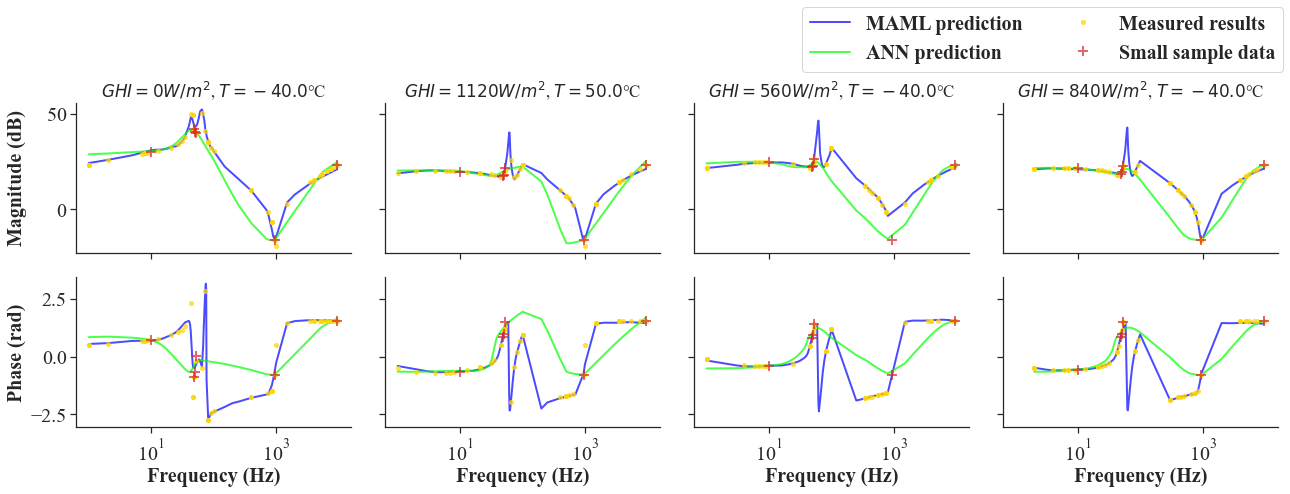

In [104]:
font = {'family' : 'Times New Roman','weight' : 'bold',
        'size': size,}

d = {'ls': ['-','-', '',''],
     'marker':['','','o','+'],
     'mfc':['','','gold','tab:red'],
     'mec':['','','gold','tab:red'],
     'fillstyle':['none','none','full',"full"],
     'lw':[2,2,2,8],
     'mew':[1,1,1,2],
     'ms':[6,6,4,10]}
g = sns.FacetGrid(df, row='type', col="conf", hue="mod", hue_kws=d, margin_titles=True,
                  sharey='row',palette=('blue','lime','r','none'),
#                   legend_out=False,
                  aspect=1.6,
                 )
g.map(plt.plot, f, "value", alpha=.7)
# g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_titles(col_template="{col_name}", row_template="")
axes = g.axes
for i in axes.flatten():
    i.set_xscale('log')
# for i in axes[0]:
#     i.set_yscale('log')
axes[0][0].set_ylabel(r, weight='bold',fontsize=size)
axes[1][0].set_ylabel(theta, weight='bold',fontsize=size)
axes[1][0].set_xlabel(f, weight='bold',fontsize=size)
axes[1][1].set_xlabel(f, weight='bold',fontsize=size)
axes[1][2].set_xlabel(f, weight='bold',fontsize=size)
axes[1][3].set_xlabel(f, weight='bold',fontsize=size)

fig = g.fig
fig.align_ylabels(axes[:, 0])
# g.set(xscale = 'log')
g.add_legend(title="",
#              loc=1,
#              bbox_to_anchor=(0.57,1.05),
             bbox_to_anchor=(0.71,1.05),
             ncol=2,
             frameon=True,
             prop=font)
fig = g.savefig('comp2.svg', dpi=400)

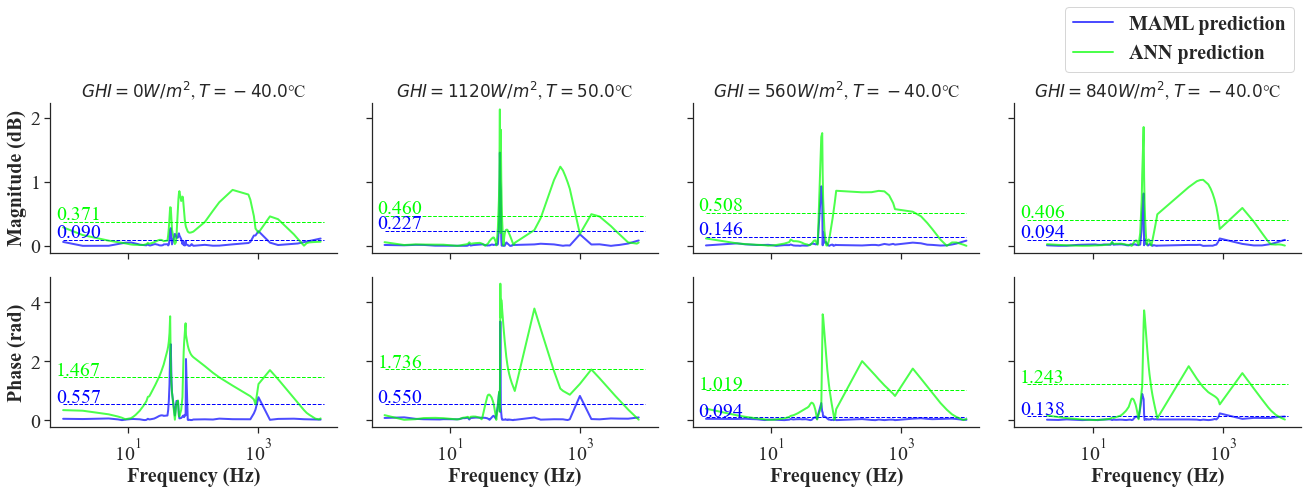

In [100]:
import numpy as np 
font = {'family' : 'Times New Roman','weight' : 'bold',
        'size': size,}

def rms(x):
    return (x**2).mean()**(1/2)


df_e['value'] = np.abs(df_e['value'])

fs = df[(df['mod']=='Small sample data') & (df['type']==r)][f]
df_e = df_e[~df_e[f].isin(fs)]

d = {'ls': ['-','-', '',''],
     'marker':['','','o','P'],
     'mfc':['','','none','tab:red'],
     'mec':['','','tab:orange','tab:red'],
     'fillstyle':['none','none','none',"full"],
     'ms':[6,6,6,8]}
g = sns.FacetGrid(df_e, row='type', col="conf", hue="mod", hue_kws=d, margin_titles=True,
                  sharey='row',palette=('blue','lime','r','none'),
                  aspect=1.6,
                 )
g.map(plt.plot, f, "value", alpha=.7, lw=2, )
# g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_titles(col_template="{col_name}", row_template="")
axes = g.axes

for v,ax in zip(df_e.groupby(['type', 'conf']), axes.flatten()):
    v = v[1]
    (_,v2), (__,v1) = v.groupby('mod')
    m1, m2 = rms(v1['value']), rms(v2['value'])
    ax.hlines(m1,1,1e4, ls='--', colors='blue',lw=1)
    ax.hlines(m2,1,1e4, ls='--', colors='lime',lw=1)
    
    
for i in axes.flatten():
    i.set_xscale('log')
# for i in axes[0]:
#     i.set_yscale('log')
              
for v,ax in zip(df_e.groupby(['type', 'conf']), axes.flatten()):
    v = v[1]
    (_,v2), (__,v1) = v.groupby('mod')
    m1, m2 = rms(v1['value']), rms(v2['value'])
    ax.text(0.02, m1+0.04, '%0.3f'%m1, color='blue', transform=ax.get_yaxis_transform(),fontsize=size)              
    ax.text(0.02, m2+0.04, '%0.3f'%m2, color='lime', transform=ax.get_yaxis_transform(),fontsize=size)
              

axes[0][0].set_ylabel(r, weight='bold',fontsize=size)
axes[1][0].set_ylabel(theta, weight='bold',fontsize=size)
axes[1][0].set_xlabel(f, weight='bold',fontsize=size)
axes[1][1].set_xlabel(f, weight='bold',fontsize=size)
axes[1][2].set_xlabel(f, weight='bold',fontsize=size)
axes[1][3].set_xlabel(f, weight='bold',fontsize=size)
# g.set(xscale = 'log')
fig = g.fig
fig.align_ylabels(axes[:, 0])

g.add_legend(title="",
#              loc='lower center',
#              bbox_to_anchor=(0.72,1.05),
             bbox_to_anchor=(0.82,1.05),
             frameon=True,
             prop=font)
fig = g.savefig('losscomp2.svg', dpi=400)